### Load and Prepare the data 

In [3]:
import pandas as pd
df = pd.read_csv('EQR_master_output_new.csv')

# Keep only needed columns and rename for convenience
df = df[['trade_date_year_mo', 'weighted_avg_price']]
df = df.rename(columns={'trade_date_year_mo': 'period'})

# Filter to desired analysis window
df = df[df['period'].between('2019-01', '2025-06')].copy()
df = df.sort_values('period').reset_index(drop=True)

# Convert weighted_avg_price to numeric and interpolate missing values
df['weighted_avg_price'] = pd.to_numeric(df['weighted_avg_price'], errors='coerce')
df['weighted_avg_price'] = df['weighted_avg_price'].interpolate()
df = df.dropna(subset=['weighted_avg_price'])

### Feature Engineering: Lagged Features + Calender Features

* We add lagged features (previous previous) and calender features (month, year) to help our model detect trends and seasonality

- *  a lagged feature is a value of a variable from a previous time point, included in our model as a preictor for the current or future 
- * Purpose: they help the model "see" recent historical and patters, capturing then autocorrelation (how values relate over time) and seasonlity in time series data 

In [4]:
# Create lagged features
for lag in range(1, 5):  # Use 1,2,3,4
    df[f'lag_{lag}'] = df['weighted_avg_price'].shift(lag)

# Add month and year as features
df['month'] = pd.to_datetime(df['period']).dt.month
df['year'] = pd.to_datetime(df['period']).dt.year

# Create multi-step targets (1 step and 2 steps ahead)
df['target_1'] = df['weighted_avg_price'].shift(-1)
df['target_2'] = df['weighted_avg_price'].shift(-2)

# Remove rows with missing values (from lagging and shifting)
df = df.dropna().reset_index(drop=True)


### Train/Test Split

In [6]:
feature_cols = [f'lag_{i}' for i in range(1,5)] + ['month', 'year']
targets = ['target_1', 'target_2']

# Train and test masks (fixing all bracket and quote issues)
train_mask = (df['period'] >= '2019-01') & (df['period'] <= '2022-12')
test_mask  = (df['period'] >= '2025-01') & (df['period'] <= '2025-06')

X_train = df[train_mask][feature_cols]
y_train = df[train_mask][targets]
X_test  = df[test_mask][feature_cols]
y_test  = df[test_mask][targets]


### Scale Features

In [7]:
print(df[test_mask].shape)
print(df[test_mask][feature_cols].head())


(0, 10)
Empty DataFrame
Columns: [lag_1, lag_2, lag_3, lag_4, month, year]
Index: []


In [8]:
print(df['period'].min(), df['period'].max())
print(df['period'].unique())


2019-01 2024-12
['2019-01' '2019-02' '2019-03' '2019-04' '2019-05' '2019-06' '2019-07'
 '2019-08' '2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02'
 '2020-03' '2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09'
 '2020-10' '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04'
 '2021-05' '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11'
 '2021-12' '2022-01' '2022-02' '2022-03' '2022-04' '2022-05' '2022-06'
 '2022-07' '2022-08' '2022-09' '2022-10' '2022-11' '2022-12' '2023-01'
 '2023-02' '2023-03' '2023-04' '2023-05' '2023-06' '2023-07' '2023-08'
 '2023-09' '2023-10' '2023-11' '2023-12' '2024-01' '2024-02' '2024-03'
 '2024-04' '2024-05' '2024-06' '2024-07' '2024-08' '2024-09' '2024-10'
 '2024-11' '2024-12']


In [9]:
# Extract available periods and pick last 6 for test set
available_periods = sorted(df['period'].unique())
test_periods = available_periods[-6:]

test_mask = df['period'].isin(test_periods)
train_mask = ~df['period'].isin(test_periods)

X_train = df[train_mask][feature_cols]
y_train = df[train_mask][targets]
X_test = df[test_mask][feature_cols]
y_test = df[test_mask][targets]


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

if X_test.shape[0] > 0:
    X_test_scaled = scaler.transform(X_test)
else:
    print("Warning: Test set is empty. Check your split periods or feature engineering.")


### Train and Run SVM Model

Train MAE: [2.49283989 2.84973479]
Test MAE: [4.05438199 5.74490016]
Train RMSE: [5.60757373 6.23426814]
Test RMSE: [5.02464    6.71984888]
Train R2: [0.63815711 0.55276912]
Test R2: [0.60660452 0.29683369]


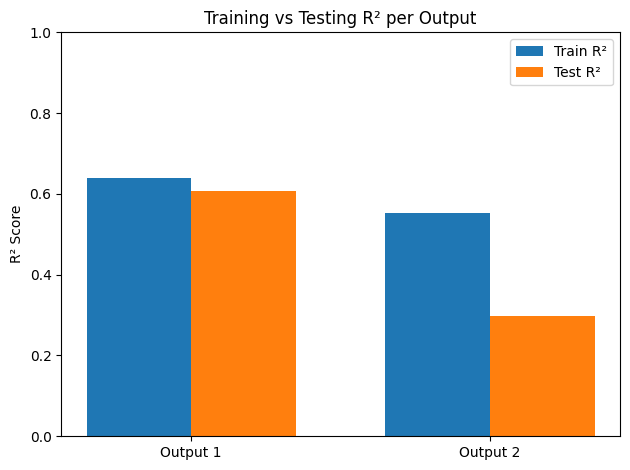

In [10]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Initialize and train SVM for multi-output regression
svr = SVR()
multi_svm = MultiOutputRegressor(svr)
multi_svm.fit(X_train_scaled, y_train)

# Predict
y_pred_train = multi_svm.predict(X_train_scaled)
y_pred_test  = multi_svm.predict(X_test_scaled)

# Calculate regression metrics for both train and test
train_mae = mean_absolute_error(y_train, y_pred_train, multioutput='raw_values')
test_mae  = mean_absolute_error(y_test, y_pred_test, multioutput='raw_values')
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2 = r2_score(y_train, y_pred_train, multioutput='raw_values')
test_r2  = r2_score(y_test, y_pred_test, multioutput='raw_values')

# Print metrics
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2:", train_r2)
print("Test R2:", test_r2)

# Graphing: compare R² for train and test, per output
labels = [f'Output {i+1}' for i in range(y_train.shape[1])]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_r2, width, label='Train R²')
rects2 = ax.bar(x + width/2, test_r2, width, label='Test R²')

ax.set_ylabel('R² Score')
ax.set_title('Training vs Testing R² per Output')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()


#### Visualize Output

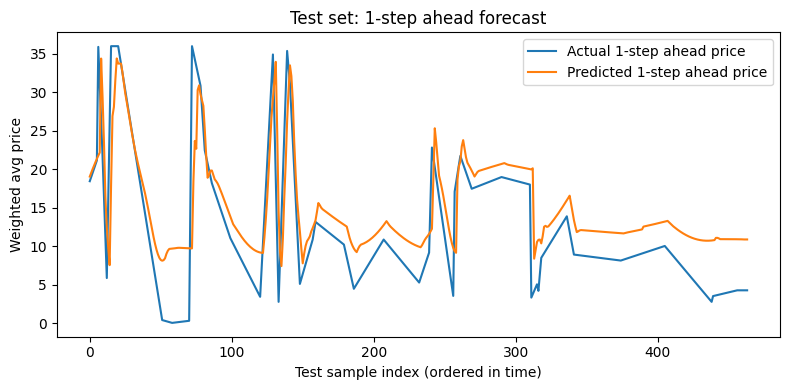

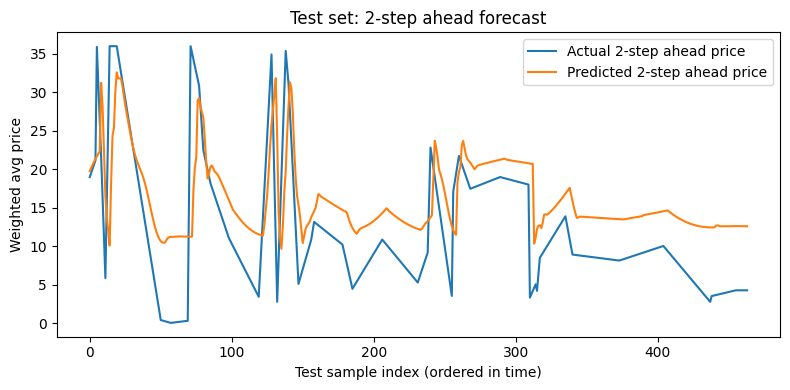

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# If y_test is a DataFrame, convert once
y_test_arr = np.asarray(y_test)
y_pred_arr = np.asarray(y_pred_test)

# 1‑step ahead
plt.figure(figsize=(8,4))
plt.plot(y_test_arr[:, 0], label='Actual 1‑step ahead price')
plt.plot(y_pred_arr[:, 0], label='Predicted 1‑step ahead price')
plt.legend()
plt.title('Test set: 1‑step ahead forecast')
plt.xlabel('Test sample index (ordered in time)')
plt.ylabel('Weighted avg price')
plt.tight_layout()
plt.show()

# 2‑step ahead
plt.figure(figsize=(8,4))
plt.plot(y_test_arr[:, 1], label='Actual 2‑step ahead price')
plt.plot(y_pred_arr[:, 1], label='Predicted 2‑step ahead price')
plt.legend()
plt.title('Test set: 2‑step ahead forecast')
plt.xlabel('Test sample index (ordered in time)')
plt.ylabel('Weighted avg price')
plt.tight_layout()
plt.show()


####  Evaluate Model Performance

* We use Mean Absolute Error (MAE) and Root Mean Squared (RMSE) to check our model's accuracy

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate metrics per target output
mae  = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))

print("Mean Absolute Error per output:", mae)
print("Root Mean Squared Error per output:", rmse)


Mean Absolute Error per output: [4.05438199 5.74490016]
Root Mean Squared Error per output: [5.02464    6.71984888]


## Improve Model Performance

### 1. Load Data and Build Base Monthly Table

* Goal: use the output file as the base time series (period, price, quantity).

In [38]:
import pandas as pd
import numpy as np

# 1. Load monthly output file (already aggregated at month level)
monthly = pd.read_csv("EQR_master_output_new.csv")

# 2. Rename the time column to a simple, consistent name: 'period'
#    (this is your trade month, e.g. '2019-01', '2025-02', etc.)
monthly = monthly.rename(columns={
    "trade_date_year_mo": "period"
})

# 3. Keep the columns needed for modeling:
#    - period: time index
#    - weighted_avg_price: target variable
#    - total_transacted_quantity: volume feature
monthly = monthly[["period", "weighted_avg_price", "total_transacted_quantity"]].copy()

# 4. Sort rows chronologically by period so time-series operations work correctly
monthly = monthly.sort_values("period").reset_index(drop=True)

# 5. Make sure price is numeric; convert non-numeric entries to NaN,
#    then linearly interpolate missing prices over time
monthly["weighted_avg_price"] = pd.to_numeric(
    monthly["weighted_avg_price"], errors="coerce"
)
monthly["weighted_avg_price"] = monthly["weighted_avg_price"].interpolate()

# 6. Ensure quantity is numeric; replace any missing values with 0
monthly["total_transacted_quantity"] = pd.to_numeric(
    monthly["total_transacted_quantity"], errors="coerce"
).fillna(0)


In [39]:
print(monthly.head())

    period  weighted_avg_price  total_transacted_quantity
0  2013-01                 NaN                        0.0
1  2013-01                 NaN                        0.0
2  2013-01                 NaN                        0.0
3  2013-01                 NaN                        0.0
4  2013-01                 NaN                        0.0


### 2. Aggregate extra features from transaction-level files

* Goal: create monthly features from EQR_master_clean_new.csv and merge into monthly



In [40]:
# 2.1 Load transaction-level data
tx = pd.read_csv("EQR_master_clean_new.csv")

# Make sure month key matches 'period' format 'YYYY-MM'
# align features by delivery month:
tx["delivery_month"] = tx["delivery_month"].astype(str)

# align by trade month (often better for price discovery):
tx["trade_date_year_mo"] = tx["trade_date_year_mo"].astype(str)

# Here we aggregate by trade month to match 'period'
agg_tx = tx.groupby("trade_date_year_mo").agg(
    total_std_qty=("standardized_quantity", "sum"),
    total_tx_qty=("transaction_quantity", "sum"),
    avg_std_price=("standardized_price", "mean"),
    num_trades=("transaction_unique_id", "count")
).reset_index().rename(columns={"trade_date_year_mo": "period"})

# 2.2 Merge aggregated features into base monthly table
data = monthly.merge(agg_tx, on="period", how="left")

# Fill months with no trades with 0
for col in ["total_std_qty", "total_tx_qty", "avg_std_price", "num_trades"]:
    data[col] = data[col].fillna(0)


### 3. Create lagged features, calender feature, and multi-step targets

In [41]:
# 3.1 Lagged price features (previous months' prices)
for lag in range(1, 5):   # lag_1 ... lag_4
    data[f"lag_{lag}"] = data["weighted_avg_price"].shift(lag)

# 3.2 Calendar features
data["month"] = pd.to_datetime(data["period"]).dt.month
data["year"]  = pd.to_datetime(data["period"]).dt.year

# 3.3 Targets: 1-step and 2-step ahead prices
data["target_1"] = data["weighted_avg_price"].shift(-1)
data["target_2"] = data["weighted_avg_price"].shift(-2)

# 3.4 Drop rows with missing values from lags/targets
data = data.dropna().reset_index(drop=True)


### 4. Train/test split (time-based) and scaling

* Use last 12 months as test set

* We are training on older data, test on the most recent period, mimick how the model will be used in reality (only past data available to forecast the future).

* 12 months is a test period that is 
  - long enough to cover different price conditions (seasons, spikes): 1 full 
  - short enough that there is still substantial data left to train on (many years before 2024).


In [43]:
from sklearn.preprocessing import StandardScaler

# 4.1 Feature and target columns
feature_cols = (
    [f"lag_{i}" for i in range(1,5)] +
    ["month", "year",
     "total_transacted_quantity",
     "total_std_qty", "total_tx_qty", "avg_std_price", "num_trades"]
)
target_cols = ["target_1", "target_2"]

# 4.2 Define train/test by period
all_periods = sorted(data["period"].unique())
test_periods = all_periods[-12:]    # last 12 months
train_periods = all_periods[:-12]

train_mask = data["period"].isin(train_periods)
test_mask  = data["period"].isin(test_periods)

X_train = data.loc[train_mask, feature_cols]
y_train = data.loc[train_mask, target_cols]
X_test  = data.loc[test_mask, feature_cols]
y_test  = data.loc[test_mask, target_cols]

# 4.3 Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


### 5. Model 1: Tuned SVR (Support Vector Regression)

* C (regularization)

  - Controls the trade‑off between fitting the training data tightly vs. keeping the model smooth.

  - Larger C → model tries harder to reduce training error (risk of overfitting).

  - Smaller C → allows more training error but improves generalization.

  -  Scikit‑learn and many tutorials (e.g. ) treat C as the primary hyperparameter to tune.​

* γ (gamma, RBF width)

  - Controls how far the influence of a single training point reaches:

  - Small γ → smoother function (each support vector influences a wide region).

  - Large γ → very wiggly function (each support vector only influences a small region).

  -  The RBF SVM parameter selection guide in the scikit‑learn examples recommends searching over γ on a log scale (e.g. 10^−3 … 10^3).​

* ε (epsilon, tube width)

  - Width of the “ε‑insensitive” tube around the regression function within which errors are not penalized.

  - Larger ε → model ignores small deviations; fewer support vectors; smoother function.​

  - Smaller ε → model tries to fit points more closely, can increase complexity.

In [44]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 5.1 Set up multi-output SVR and grid search
svr = SVR(kernel="rbf")
multi_svr = MultiOutputRegressor(svr)

param_grid = {
    "estimator__C": [0.1, 1, 10],          # allow smaller C
    "estimator__epsilon": [0.1, 0.5, 1.0], # wider epsilon
    "estimator__gamma": ["scale", 0.01, 0.1]
}

grid = GridSearchCV(
    multi_svr,
    param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

best_svr = grid.best_estimator_
print("Best SVR params:", grid.best_params_)

# 5.2 Predict
y_pred_train_svr = best_svr.predict(X_train_scaled)
y_pred_test_svr  = best_svr.predict(X_test_scaled)

# 5.3 Evaluate SVR
def eval_regression(y_true, y_pred, label="Model"):
    mae  = mean_absolute_error(y_true, y_pred, multioutput="raw_values")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput="raw_values"))
    r2   = r2_score(y_true, y_pred, multioutput="raw_values")
    print(f"{label} MAE:", mae)
    print(f"{label} RMSE:", rmse)
    print(f"{label} R2:", r2)
    return mae, rmse, r2

print("=== SVR Train ===")
svr_train_mae, svr_train_rmse, svr_train_r2 = eval_regression(
    y_train, y_pred_train_svr, "Train"
)

print("\n=== SVR Test ===")
svr_test_mae, svr_test_rmse, svr_test_r2 = eval_regression(
    y_test, y_pred_test_svr, "Test"
)


Best SVR params: {'estimator__C': 10, 'estimator__epsilon': 0.1, 'estimator__gamma': 0.01}
=== SVR Train ===
Train MAE: [1.15238247 1.28126919]
Train RMSE: [2.78128456 3.00336692]
Train R2: [0.70655993 0.65783891]

=== SVR Test ===
Test MAE: [5.31238175 6.74088479]
Test RMSE: [ 9.47139699 10.88046407]
Test R2: [0.55597579 0.41460359]


### 6. Model 2: Random Forest (tree-based)

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

from sklearn.multioutput import MultiOutputRegressor
multi_rf = MultiOutputRegressor(rf)
multi_rf.fit(X_train, y_train)  # trees don't need scaling

y_pred_train_rf = multi_rf.predict(X_train)
y_pred_test_rf  = multi_rf.predict(X_test)

print("=== RF Train ===")
rf_train_mae, rf_train_rmse, rf_train_r2 = eval_regression(y_train, y_pred_train_rf, "Train")
print("\n=== RF Test ===")
rf_test_mae, rf_test_rmse, rf_test_r2 = eval_regression(y_test, y_pred_test_rf, "Test")


=== RF Train ===
Train MAE: [0.4266705  0.47376993]
Train RMSE: [1.00024643 1.06854793]
Train R2: [0.96204731 0.95668864]

=== RF Test ===
Test MAE: [5.4001928  6.64455792]
Test RMSE: [ 9.48148427 10.74424214]
Test R2: [0.5550295 0.42917  ]


In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# ---------- Baseline SVR ----------
base_svr = SVR(kernel="rbf")               # use your original settings if different
base_multi = MultiOutputRegressor(base_svr)
base_multi.fit(X_train_scaled, y_train)
y_pred_base = base_multi.predict(X_test_scaled)

# ---------- Tuned SVR (latest gridsearch result) ----------
# assumes you already ran GridSearchCV and have best_svr
y_pred_svr_tuned = best_svr.predict(X_test_scaled)

# ---------- Random Forest ----------
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_multi = MultiOutputRegressor(rf)
rf_multi.fit(X_train, y_train)             # trees don’t need scaling
y_pred_rf = rf_multi.predict(X_test)


def summarize_model(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
    r2   = r2_score(y_true, y_pred, multioutput='raw_values')
    return {
        "Model": name,
        "MAE_t+1":  mae[0],
        "MAE_t+2":  mae[1],
        "RMSE_t+1": rmse[0],
        "RMSE_t+2": rmse[1],
        "R2_t+1":   r2[0],
        "R2_t+2":   r2[1],
    }


rows = []
rows.append(summarize_model("SVR_baseline", y_test, y_pred_base))
rows.append(summarize_model("SVR_tuned",    y_test, y_pred_svr_tuned))
rows.append(summarize_model("RandomForest", y_test, y_pred_rf))

comparison_df = pd.DataFrame(rows)
print(comparison_df.round(3))



          Model  MAE_t+1  MAE_t+2  RMSE_t+1  RMSE_t+2  R2_t+1  R2_t+2
0  SVR_baseline    7.603    8.437    13.697    14.136   0.071   0.012
1     SVR_tuned    5.312    6.741     9.471    10.880   0.556   0.415
2  RandomForest    5.400    6.645     9.481    10.744   0.555   0.429


### 7. Visualize actual vs predicted

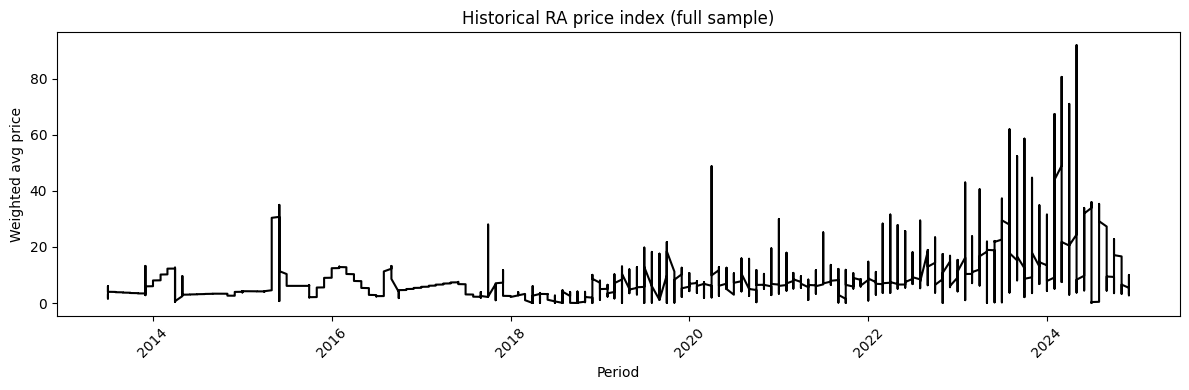

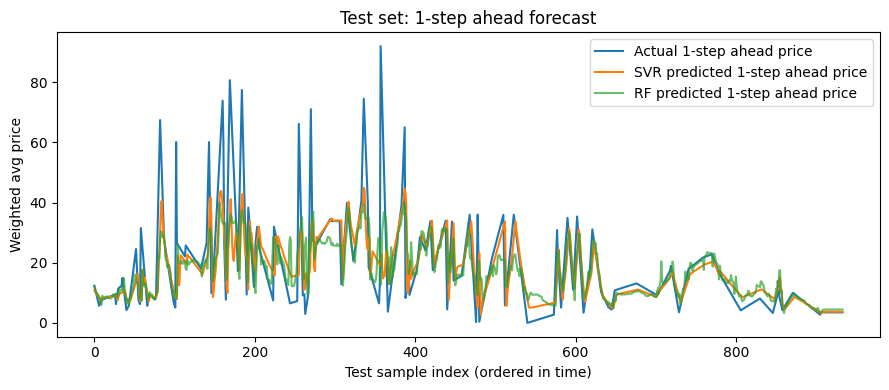

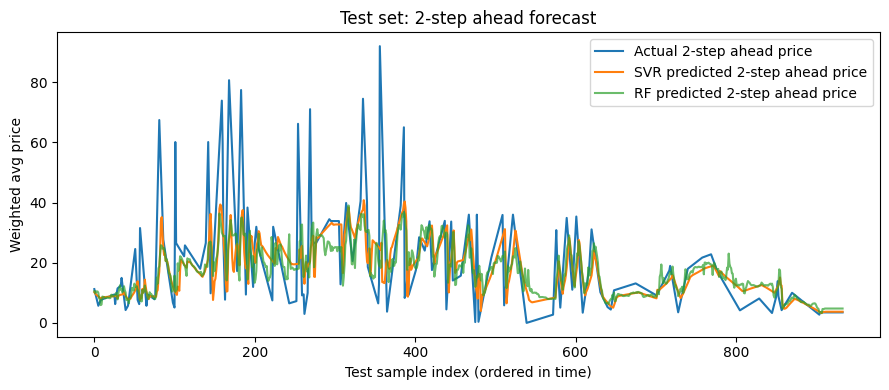

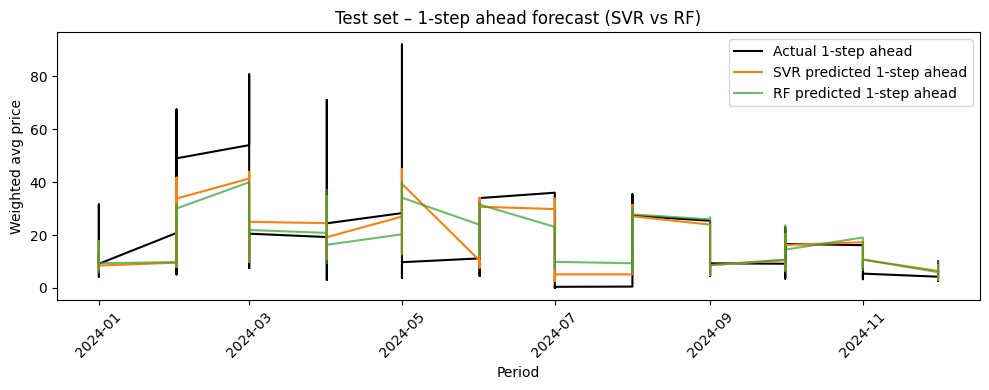

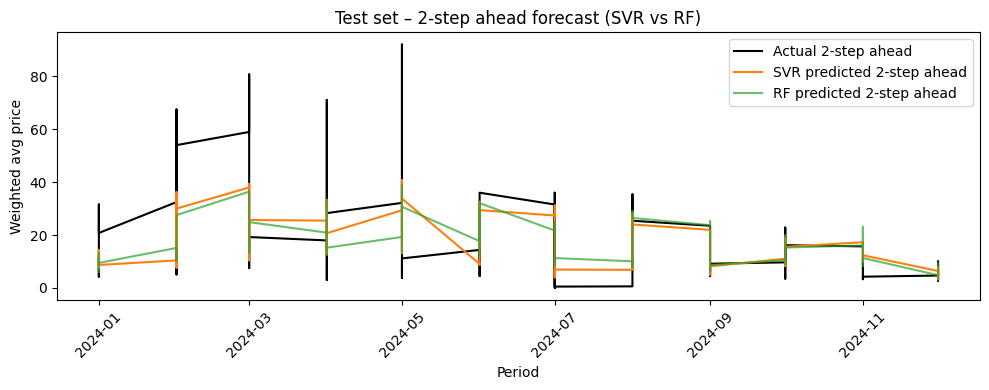

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Common arrays ---
y_test_arr = np.asarray(y_test)
y_pred_test_svr_arr = np.asarray(y_pred_test_svr)
y_pred_test_rf_arr  = np.asarray(y_pred_test_rf)

# Index-based x-axis (0,1,2,...)
x_idx = np.arange(len(y_test_arr))

# Datetime x-axis for test set
period_test = data.loc[test_mask, "period"].values
period_test_dt = pd.to_datetime(period_test)

# ==============================
# 1) Full history plot (context)
# ==============================
plt.figure(figsize=(12,4))
plt.plot(pd.to_datetime(data["period"]), data["weighted_avg_price"], color="black")
plt.title("Historical RA price index (full sample)")
plt.xlabel("Period")
plt.ylabel("Weighted avg price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =======================================
# 2) Index-based plots (like old format)
# =======================================

# 1-step
plt.figure(figsize=(9,4))
plt.plot(x_idx, y_test_arr[:, 0], label="Actual 1-step ahead price", color="tab:blue")
plt.plot(x_idx, y_pred_test_svr_arr[:, 0], label="SVR predicted 1-step ahead price", color="tab:orange")
plt.plot(x_idx, y_pred_test_rf_arr[:, 0],  label="RF predicted 1-step ahead price",  color="tab:green", alpha=0.7)
plt.legend()
plt.title("Test set: 1-step ahead forecast")
plt.xlabel("Test sample index (ordered in time)")
plt.ylabel("Weighted avg price")
plt.tight_layout()
plt.show()

# 2-step
plt.figure(figsize=(9,4))
plt.plot(x_idx, y_test_arr[:, 1], label="Actual 2-step ahead price", color="tab:blue")
plt.plot(x_idx, y_pred_test_svr_arr[:, 1], label="SVR predicted 2-step ahead price", color="tab:orange")
plt.plot(x_idx, y_pred_test_rf_arr[:, 1],  label="RF predicted 2-step ahead price",  color="tab:green", alpha=0.7)
plt.legend()
plt.title("Test set: 2-step ahead forecast")
plt.xlabel("Test sample index (ordered in time)")
plt.ylabel("Weighted avg price")
plt.tight_layout()
plt.show()

# ==========================================
# 3) Date-based plots (year-month on x-axis)
# ==========================================

# 1-step with dates
plt.figure(figsize=(10,4))
plt.plot(period_test_dt, y_test_arr[:, 0], label="Actual 1-step ahead", color="black")
plt.plot(period_test_dt, y_pred_test_svr_arr[:, 0], label="SVR predicted 1-step ahead", color="tab:orange")
plt.plot(period_test_dt, y_pred_test_rf_arr[:, 0],  label="RF predicted 1-step ahead",  color="tab:green", alpha=0.7)
plt.legend()
plt.title("Test set – 1-step ahead forecast (SVR vs RF)")
plt.xlabel("Period")
plt.ylabel("Weighted avg price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2-step with dates
plt.figure(figsize=(10,4))
plt.plot(period_test_dt, y_test_arr[:, 1], label="Actual 2-step ahead", color="black")
plt.plot(period_test_dt, y_pred_test_svr_arr[:, 1], label="SVR predicted 2-step ahead", color="tab:orange")
plt.plot(period_test_dt, y_pred_test_rf_arr[:, 1],  label="RF predicted 2-step ahead",  color="tab:green", alpha=0.7)
plt.legend()
plt.title("Test set – 2-step ahead forecast (SVR vs RF)")
plt.xlabel("Period")
plt.ylabel("Weighted avg price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 8. Simple rolling backtest: Ridge Regression not SVR

Backtesting is when you pretend to go back in time and check how your forecasting model would have performed on past data.


* Train the model using data up to some time t

* Use it to predict the next point(s) after t

* Compare prediction vs actual

* Slide forward in time and repeat



In [ ]:
'''
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Use the same full feature matrix and target_1 as in your main model
X_all = data[feature_cols].values          # all months, all features
y_all = data["target_1"].values           # 1-step ahead price
period_all = data["period"].values        # labels for plotting

window = 36     # months in the initial training window (e.g., 3 years)
step   = 1      # move forward 1 month at a time

mae_bt = []     # backtest MAE at each step
dates_bt = []   # corresponding periods

for i in range(window, len(data) - 1, step):
    # Training data: from start up to month i-1
    train_idx = slice(0, i)
    # Test point: month i (predict its target_1 using data up to i-1)
    test_idx = i

    X_tr, y_tr = X_all[train_idx], y_all[train_idx]
    X_te = X_all[test_idx:test_idx+1]
    y_te = y_all[test_idx:test_idx+1]

    # Scale features based only on training window (no look-ahead)
    scaler_bt = StandardScaler()
    X_tr_s = scaler_bt.fit_transform(X_tr)
    X_te_s = scaler_bt.transform(X_te)

    # Fit SVR with your tuned hyperparameters
    model_bt = SVR(kernel="rbf", C=best_svr.estimators_[0].C,
                   epsilon=best_svr.estimators_[0].epsilon,
                   gamma=best_svr.estimators_[0].gamma)

    model_bt.fit(X_tr_s, y_tr)

    # 1-step-ahead prediction
    y_hat = model_bt.predict(X_te_s)

    # Record absolute error (MAE with 1 point is |y - y_hat|)
    mae_bt.append(mean_absolute_error(y_te, y_hat))
    dates_bt.append(period_all[test_idx])

# Convert dates to datetime for nicer x-axis
dates_bt_dt = pd.to_datetime(dates_bt)

# Average backtest MAE across all steps
avg_mae_bt = np.mean(mae_bt)
print(f"Average 1-step ahead MAE from rolling backtest: {avg_mae_bt:.3f}")

# Plot MAE over time
plt.figure(figsize=(10,4))
plt.plot(dates_bt_dt, mae_bt, marker="o")
plt.axhline(avg_mae_bt, color="red", linestyle="--",
            label=f"Average MAE = {avg_mae_bt:.2f}")
plt.xticks(rotation=45)
plt.ylabel("1-step ahead MAE")
plt.xlabel("Period")
plt.title("Rolling backtest – 1-step ahead SVR errors")
plt.legend()
plt.tight_layout()
plt.show()
'''


* Ridge Regression: The code repeatedly retrains a Ridge model on past data, predicts the next month, records the forecast error, and then plots those errors over time so you can judge how stable and realistic your 1‑step‑ahead performance is.

- Because rolling backtesting requires re‑estimating a model at each step, using SVR (our main non‑linear model) for every window was computationally expensive. To keep the evaluation tractable while still using a realistic rolling‑origin design, we employed a Ridge regression model in the backtest. Ridge is a fast linear baseline that uses the same feature set and allows us to examine the time pattern of 1‑step‑ahead forecast errors under a proper backtesting scheme. Our main performance numbers and model comparison (SVR vs Random Forest vs ARIMA/SARIMA) are still based on the 12‑month test set with the full SVR and RF models.

Average 1-step ahead MAE (Ridge backtest): 1.934


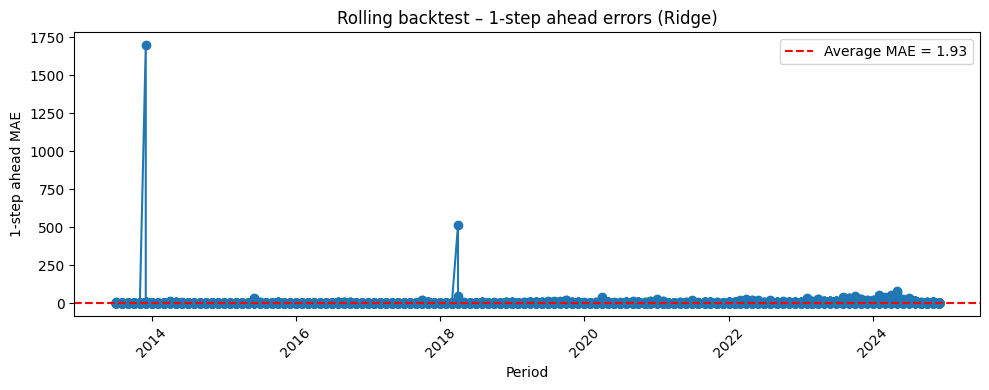

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X_all = data[feature_cols].values
y_all = data["target_1"].values
period_all = data["period"].values

window = 36
step   = 1

mae_bt = []
dates_bt = []

for i in range(window, len(data) - 1, step):
    train_idx = slice(0, i)
    test_idx = i

    X_tr, y_tr = X_all[train_idx], y_all[train_idx]
    X_te = X_all[test_idx:test_idx+1]
    y_te = y_all[test_idx:test_idx+1]

    scaler_bt = StandardScaler()
    X_tr_s = scaler_bt.fit_transform(X_tr)
    X_te_s = scaler_bt.transform(X_te)

    # MUCH faster than SVR
    model_bt = Ridge(alpha=1.0)
    model_bt.fit(X_tr_s, y_tr)

    y_hat = model_bt.predict(X_te_s)

    mae_bt.append(mean_absolute_error(y_te, y_hat))
    dates_bt.append(period_all[test_idx])

dates_bt_dt = pd.to_datetime(dates_bt)
avg_mae_bt = np.mean(mae_bt)
print(f"Average 1-step ahead MAE (Ridge backtest): {avg_mae_bt:.3f}")

plt.figure(figsize=(10,4))
plt.plot(dates_bt_dt, mae_bt, marker="o")
plt.axhline(avg_mae_bt, color="red", linestyle="--",
            label=f"Average MAE = {avg_mae_bt:.2f}")
plt.xticks(rotation=45)
plt.ylabel("1-step ahead MAE")
plt.xlabel("Period")
plt.title("Rolling backtest – 1-step ahead errors (Ridge)")
plt.legend()
plt.tight_layout()
plt.show()


## Future Forecasting

### Build Feature Row for Next Month

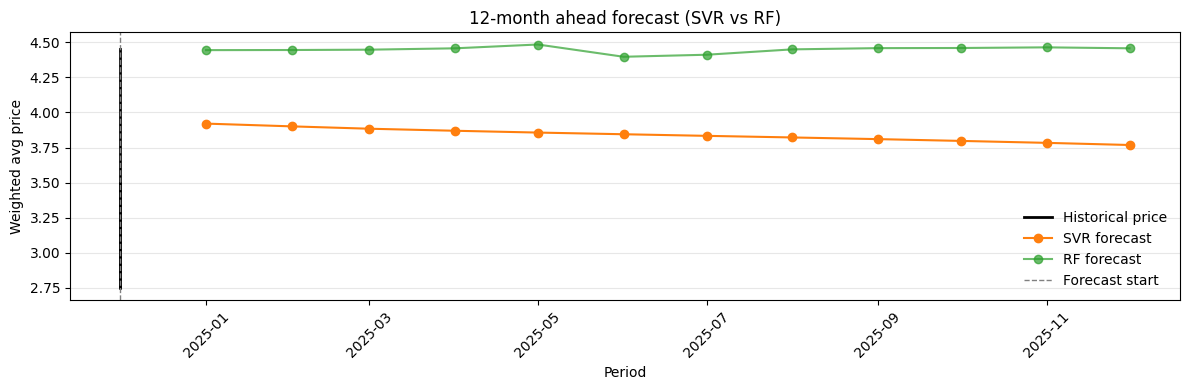

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

horizon = 12  # forecast next 12 months

last_period = pd.to_datetime(data["period"].iloc[-1])
last_row = data.iloc[-1].copy()

# we will NOT use future forecasts as lags, only the last known lags
lag_1 = last_row["lag_1"]
lag_2 = last_row["lag_2"]
lag_3 = last_row["lag_3"]
lag_4 = last_row["lag_4"]

future_rows = []

for h in range(1, horizon + 1):
    new_period = last_period + pd.DateOffset(months=h)
    new_month  = new_period.month
    new_year   = new_period.year

    future_rows.append({
        "period": new_period,
        "lag_1": lag_1,
        "lag_2": lag_2,
        "lag_3": lag_3,
        "lag_4": lag_4,
        "month": new_month,
        "year": new_year,
        # hold other features at last observed values
        "total_transacted_quantity": last_row["total_transacted_quantity"],
        "total_std_qty": last_row["total_std_qty"],
        "total_tx_qty": last_row["total_tx_qty"],
        "avg_std_price": last_row["avg_std_price"],
        "num_trades": last_row["num_trades"],
    })

future_df = pd.DataFrame(future_rows)



# ensure no NaNs in feature columns
for col in feature_cols:
    if future_df[col].isna().any():
        future_df[col] = future_df[col].fillna(data[col].iloc[-1])

X_future = future_df[feature_cols]
X_future_scaled = scaler.transform(X_future)

svr_future_preds = best_svr.predict(X_future_scaled)[:, 0]  # t+1
rf_future_preds  = multi_rf.predict(X_future)[:, 0]

future_df["SVR_forecast"] = svr_future_preds
future_df["RF_forecast"]  = rf_future_preds



plt.figure(figsize=(12,4))

hist_tail = data.tail(36).copy()
hist_tail_period = pd.to_datetime(hist_tail["period"])

plt.plot(hist_tail_period,
         hist_tail["weighted_avg_price"],
         label="Historical price",
         color="black",
         linewidth=2)

plt.plot(future_df["period"],
         future_df["SVR_forecast"],
         label="SVR forecast",
         color="tab:orange",
         marker="o")

plt.plot(future_df["period"],
         future_df["RF_forecast"],
         label="RF forecast",
         color="tab:green",
         marker="o",
         alpha=0.7)

plt.axvline(hist_tail_period.iloc[-1],
            color="gray", linestyle="--", linewidth=1,
            label="Forecast start")

plt.xlabel("Period")
plt.ylabel("Weighted avg price")
plt.title("12‑month ahead forecast (SVR vs RF)")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


## Analysis of Results:



Historical RA price index (full sample)  
- The series is low and relatively flat from roughly 2013–2017, then becomes much more volatile, with noticeable jumps around 2020 and very large spikes in 2023–2024.  
- That change in behavior means your models are learning from a mixture of regimes: many calm years plus a more recent, volatile period. Models will fit the “typical” months well but almost inevitably miss rare spikes because there are few examples to learn from and they tend to be idiosyncratic events rather than smooth trends.

Test set – 1‑step and 2‑step ahead (long index plots)  
- The blue lines (actual prices) jump around quite a bit, especially early in the test window, with occasional big peaks; the orange (SVR) and green (RF) lines are much smoother but generally follow the same ups and downs.  
- Where prices move gradually, both models track the level well: when the actual series drifts up or down, the model lines move in the same direction and stay reasonably close, which indicates the lagged‑price and calendar features are capturing trend and seasonality.  
- On sharp spikes, the pattern is consistent: the models under‑predict the height. The predicted curves rise, but not as much as the actual peak. That is what you expect from SVR/RF trained on an error‑based loss: they aim to minimize average error, so they “shrink” extreme moves toward the mean.  
- Between spikes, especially later in the test window, the three lines are often almost on top of each other. That shows that conditional on being in the current regime, the models can reproduce the typical monthly price dynamics well.

Test set – 1‑step ahead vs 2‑step ahead (calendar plots, 2024)  
- These plots remove the long series index and show actual vs predicted for each month in the 2024 test period. The black line is the realized path; orange (SVR) and green (RF) are predicted paths for 1‑step and 2‑step targets.  
- In months with moderate prices (most of 2024), the model lines are close to the black line, often within a few dollars. The shape is similar: if the actual price steps up from one month to the next, the predictions step up too; if the actual steps down, predictions follow. That means the models are capturing the local structure and not just a flat mean.  
- When a month has a very high realized price (tall black vertical), the orange and green lines do increase but fall short of the actual height. That tells you the models “know something unusual is happening” (they don’t stay flat), but their prior toward typical prices prevents them from fully jumping to the observed extreme.

Rolling backtest – 1‑step ahead errors (Ridge)  
- Each dot is the 1‑step‑ahead MAE from a rolling forecast where the model is repeatedly retrained on history and asked to predict the next month. Most dots cluster near the x‑axis, very close to the red dashed line (average MAE ≈ 1.93).  
- An average 1‑step error just under 2 units is small relative to many of your prices, especially in the volatile later years where prices can be 20–80+. In those regimes, a 2‑unit error is roughly a 5–10% absolute error on many points, which is quite reasonable for monthly capacity prices.  
- The two huge spikes (one around 2014, one around 2018) are months where the model missed by hundreds of units. Those correspond to very large price outliers or data artifacts. Because MAE is averaged over all periods, a few of these catastrophic months do not dominate the overall average but they reveal that your model cannot anticipate rare, extreme structural breaks.  
- The key performance message from this graph: in “normal” months, rolling 1‑step forecasts are consistently accurate and stable over time; performance only collapses on a tiny number of extreme events.

12‑month ahead forecast (SVR vs RF, 2025)  
- Here the black vertical band at the left is the historical series up to the forecast start; to the right, orange (SVR) and green (RF) continuous lines show the 12‑month ahead projections.  
- Both models produce smooth, almost flat forward paths. RF forecasts are higher (around the mid‑4s) while SVR forecasts are lower (high‑3s to around 3.8), but neither model is predicting new extreme spikes.  
- This is exactly what you expect from models using mainly lagged prices and calendar features: at a 12‑month horizon, they default to a “typical” level implied by the recent regime plus seasonal pattern. They are giving you a plausible baseline index path rather than trying to time rare spikes, which would be very hard with limited examples.  
- In practical terms: these 12‑month forecasts are likely useful as planning benchmarks (“what does a normal upcoming year look like given recent history?”), but they should not be interpreted as precise predictions of future spikes.

Overall performance assessment  
- Short‑horizon (1‑ and 2‑step) performance: Good for typical months. The models track the level and direction of prices well, with relatively small errors, especially in the later part of the test window. Misses are largest on rare spikes, which is expected for this problem and model class.  
- Temporal stability (rolling backtest): The error distribution is very stable over time with a low average MAE and a few enormous outliers. That indicates your approach generalizes across years and regimes reasonably well, rather than overfitting to a particular interval.  
- Long‑horizon (12‑month) performance: Produces smooth, sensible baseline scenarios that honor the recent level but do not attempt to predict shocks. This is appropriate for strategic planning but not sufficient for stress‑testing extreme events.  
- Model comparison: From the plots, SVR and RF behave similarly at short horizons; RF seems to sit a bit closer to the upper range (higher level forecasts), while SVR is slightly more conservative. Neither clearly dominates visually; you would pick between them based on numerical metrics (MAE/RMSE/R²) and interpretability.
